In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [4]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [5]:
cfg.params.low_pass = 0.1
cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

# cfg.params.low_pass = None
# cfg.params.high_pass = None

In [6]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [7]:
data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
cfg.params.data_class = data_class

In [8]:
verbose = False
agent_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    if agent == 'propofol':
        cfg.params.grid_set = 'grid_set5'
    else:
        cfg.params.grid_set = 'grid_set4'

    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        bad_session_list = ['PEDRI_Ketamine_20220113', 'PEDRI_Ketamine_20220126', 'PEDRI_Ketamine_20220203', 'PEDRI_Ketamine_20220222', 'SPOCK_Ketamine_20210722', 'SPOCK_Ketamine_20210730']
        session_list = [session for session in session_list if session not in bad_session_list]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info
    
    pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=verbose)
    agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen
    all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete grid search - cannot continue")

    grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['grid_params_to_use'] = grid_params_to_use
    all_indices_to_run = collect_delase_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, grid_params_to_use, verbose=verbose)
    
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete DeLASE - cannot continue")

    delase_results = get_delase_results(cfg, session_list, areas, grid_params_to_use, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['delase_results'] = delase_results

  0%|          | 0/3 [00:00<?, ?it/s]

Only 0 valid windows could be found for section 'awake lever1' with times [np.float64(-36.23385444444445), np.float64(-26.050830555555557)]
Only 3 valid windows could be found for section 'early unconscious' with times [np.float64(26.003301111111107), 45]
Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]
Only 3 valid windows could be found for section 'awake lever1' with times [np.float64(-36.10079944444445), np.float64(-26.03974944444445)]
Only 0 valid windows could be found for section 'awake lever2' with times [np.float64(-10.029036111111115), 0]


In [9]:
top_percent = 0.1
dose = 'high'

In [10]:
def get_num_crs(delase_results, session, top_percent=0.1):
    return delase_results[session]['all'].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).sum()
def get_num_crs_pos(delase_results, session, top_percent=0.1):
    return delase_results[session]['all'].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))][x[:int(top_percent*len(x))] >= 0])).sum()

In [11]:
for (data_class, agent), data_dict in agent_data.items():
    print(f"{agent}:")
    delase_results = data_dict['delase_results']
    num_crs = [get_num_crs(delase_results, session, top_percent) for session in delase_results.keys()]
    num_crs_pos = [get_num_crs_pos(delase_results, session, top_percent) for session in delase_results.keys()]
    total_crs = np.sum(num_crs)
    total_crs_pos = np.sum(num_crs_pos)
    total_crs_neg = total_crs - total_crs_pos
    print(f"Total CRs: {total_crs}")
    print(f"Positive CRs: {total_crs_pos} ({total_crs_pos/total_crs*100:.2f}%)")
    print(f"Negative CRs: {total_crs_neg} ({total_crs_neg/total_crs*100:.2f}%)")

propofol:
Total CRs: 1748991
Positive CRs: 19842 (1.13%)
Negative CRs: 1729149 (98.87%)
ketamine:
Total CRs: 2223427
Positive CRs: 5718 (0.26%)
Negative CRs: 2217709 (99.74%)
dexmedetomidine:
Total CRs: 3176307
Positive CRs: 12197 (0.38%)
Negative CRs: 3164110 (99.62%)


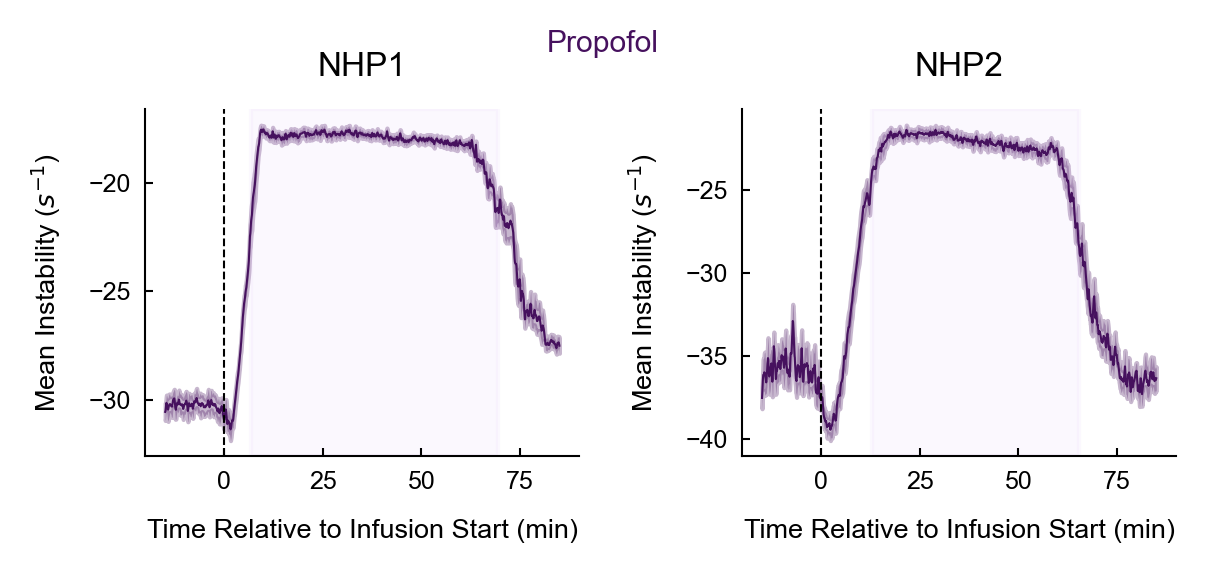

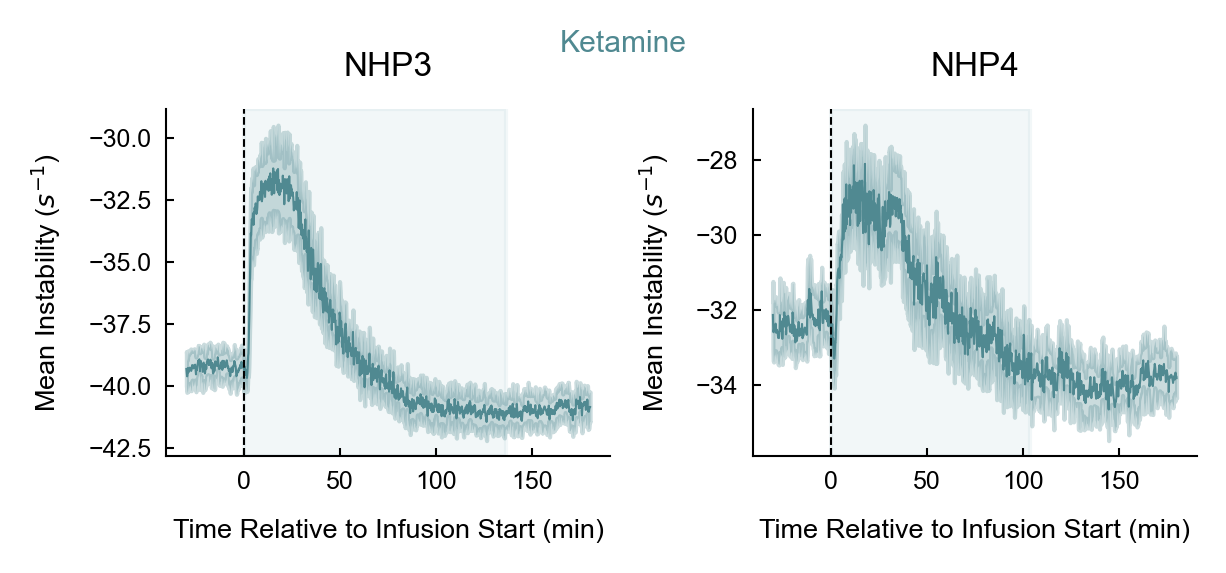

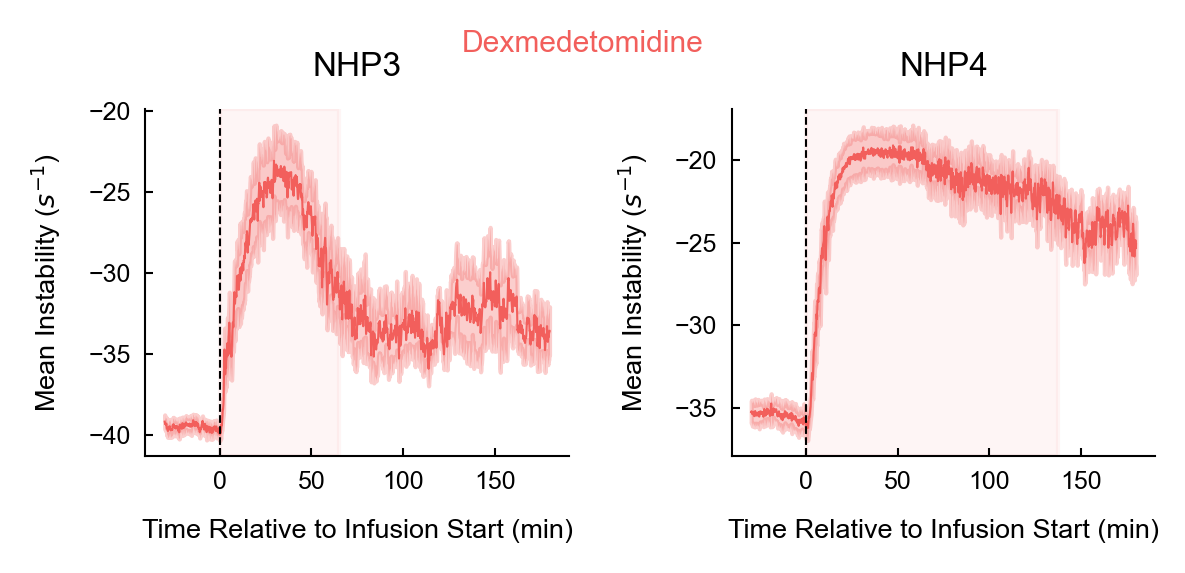

In [11]:

for (data_class, agent), data_dict in agent_data.items():
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_instability_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_instability_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    cfg.params.data_class = data_class
    plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=False,
        plot_range=(-15, 85) if agent == 'propofol' else (-30, 180), 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True
    )


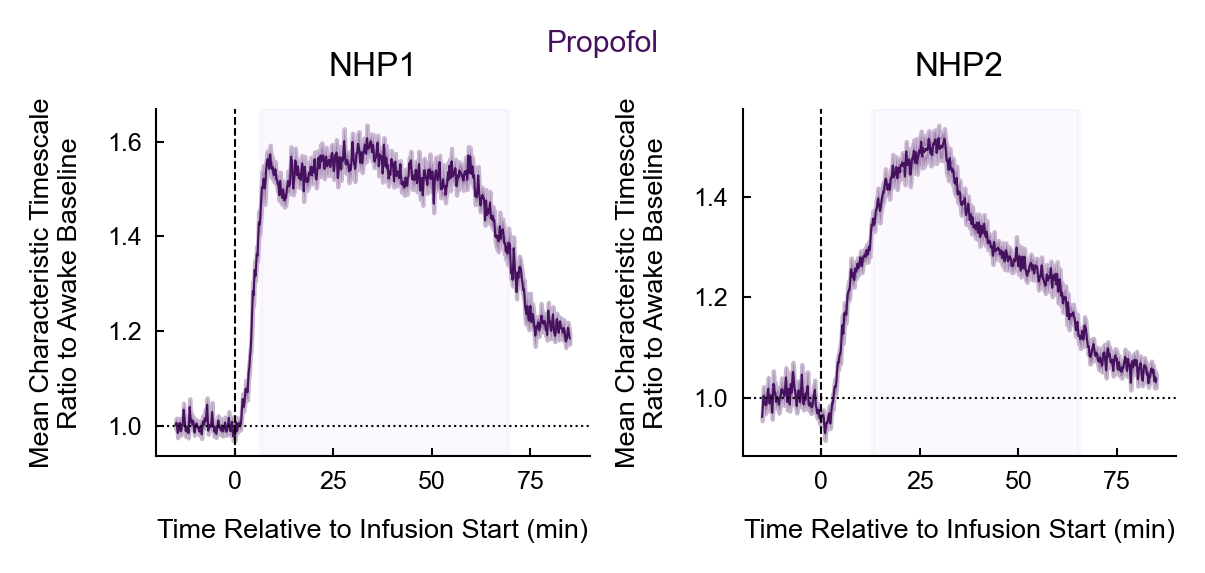

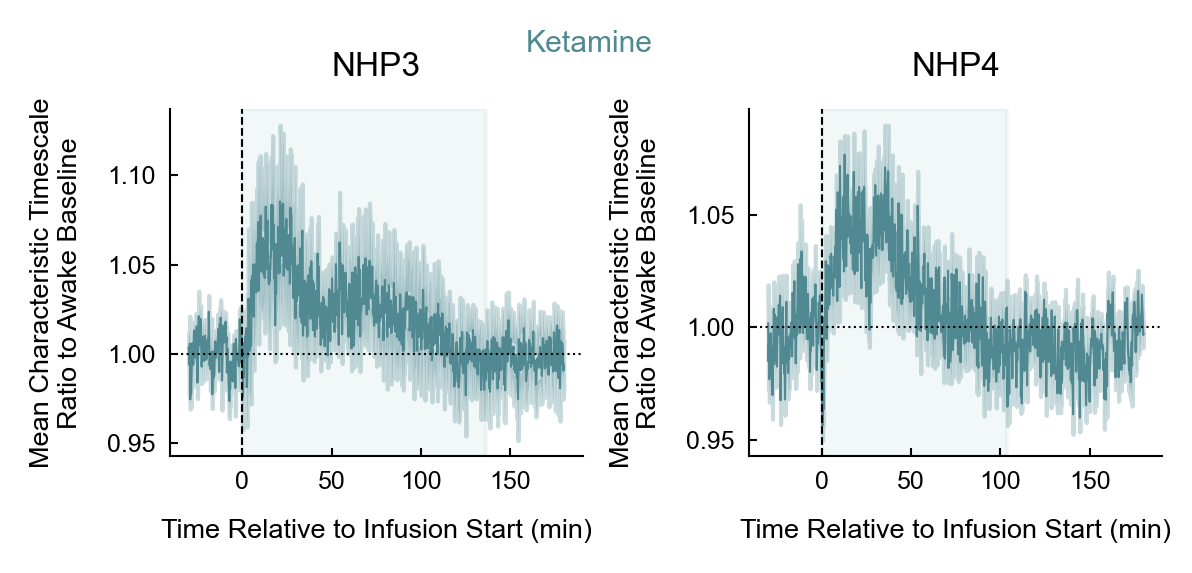

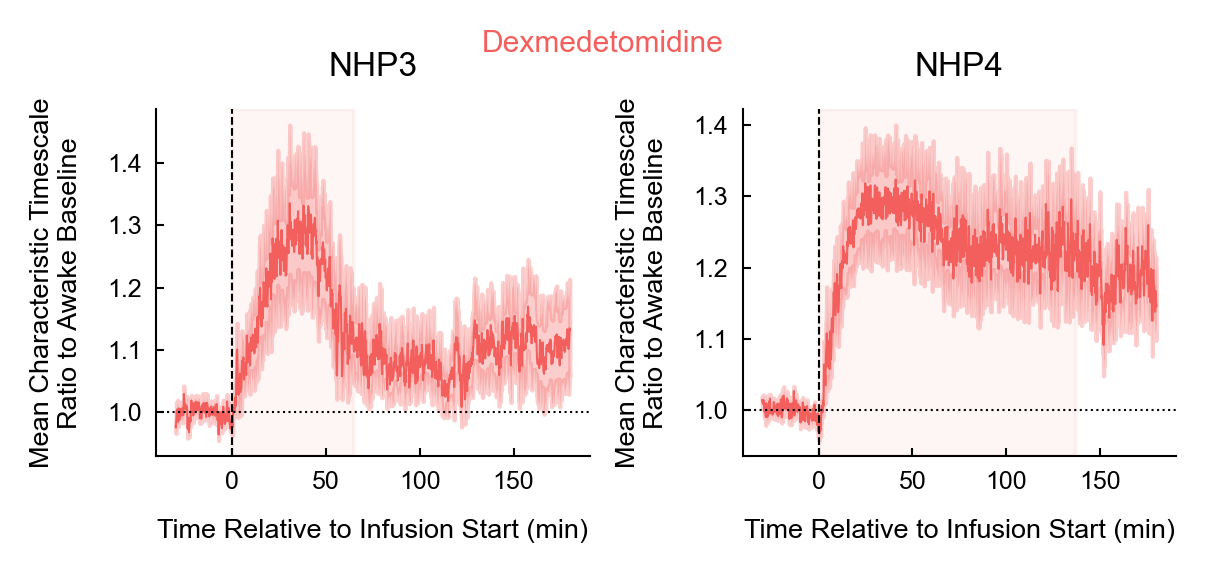

In [12]:

for (data_class, agent), data_dict in agent_data.items():
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    cfg.params.data_class = data_class
    plot_session_stability_grouped(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        data_dict['locs'], 
        data_dict['rocs'], 
        data_dict['ropaps'],
        timescales=True,
        plot_range=(-15, 85) if agent == 'propofol' else (-30, 180), 
        top_percent=top_percent, 
        curve_colors=curve_colors, 
        loc_roc_colors=loc_roc_colors, 
        figsize=(4, 2),
        dose=dose,
        save_path=save_path,
        verbose=True
    )


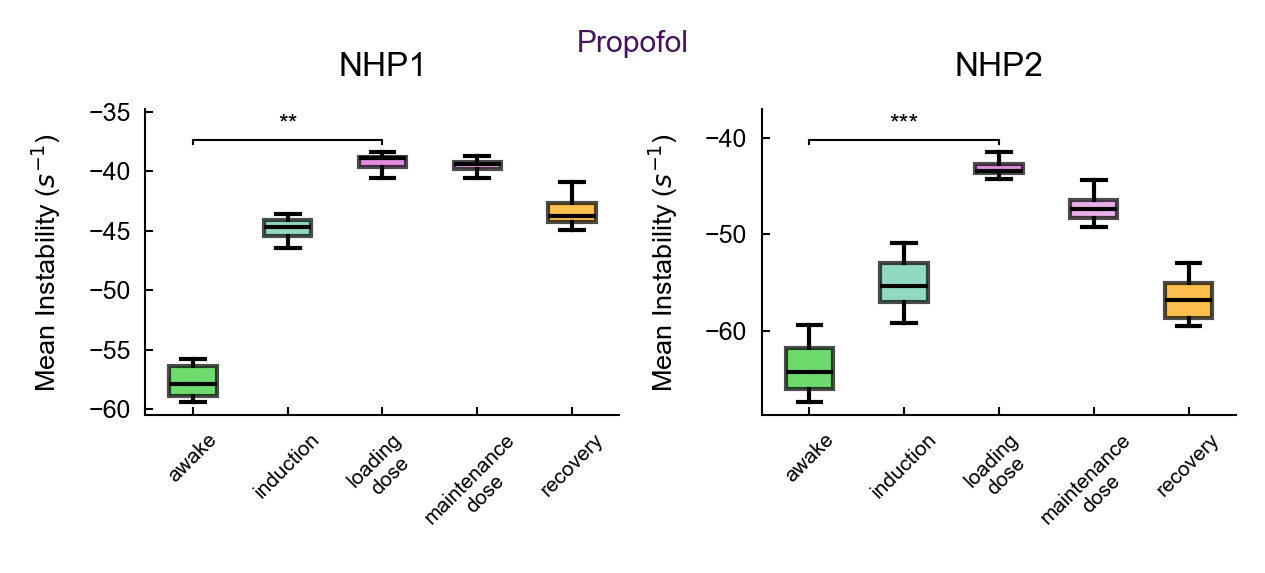

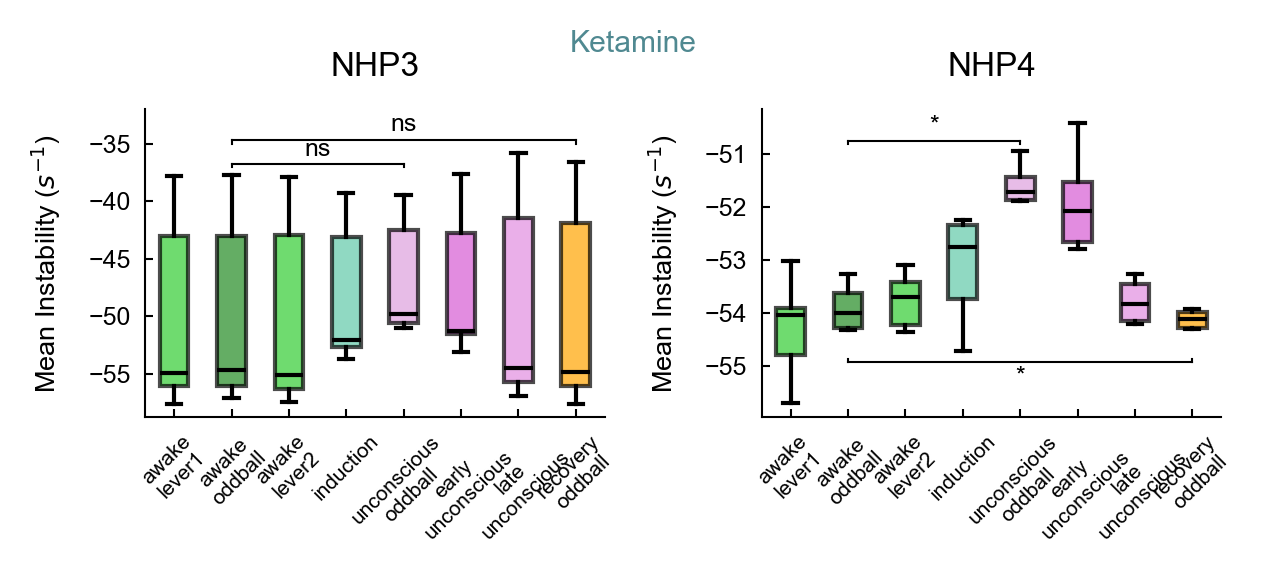

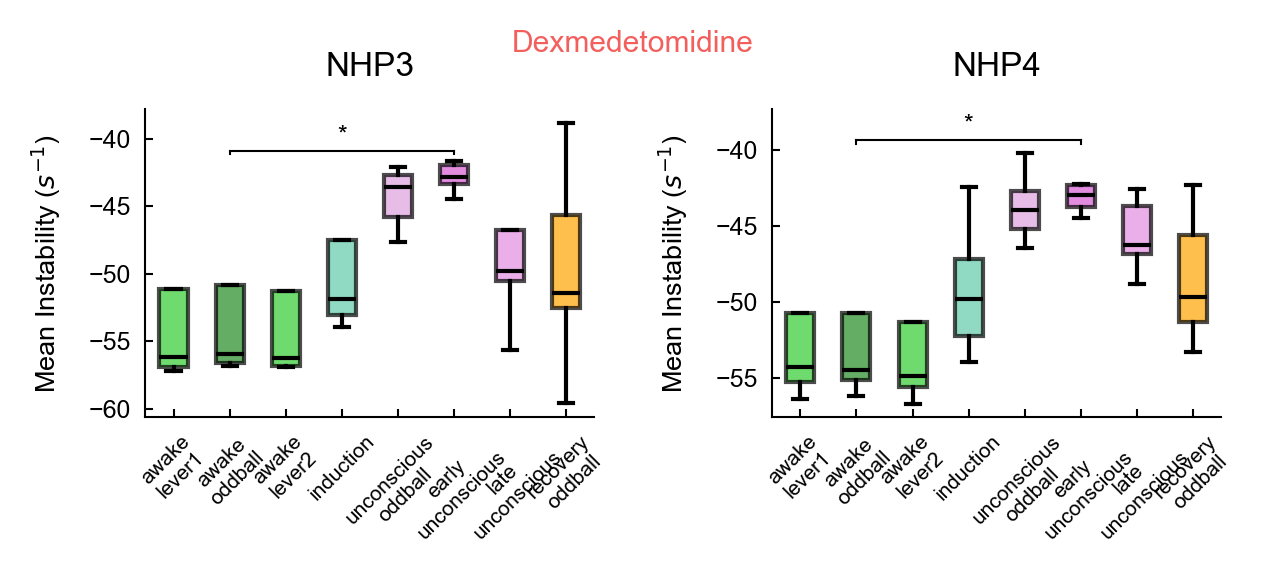

In [12]:

for (data_class, agent), data_dict in agent_data.items():
    if dose == 'high':
        save_path = os.path.join(img_save_dir, f"{agent}_section_stability_boxes_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    else:
        save_path = os.path.join(img_save_dir, f"{agent}_section_stability_boxes_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}.pdf")
    cfg.params.data_class = data_class
    plot_section_stability_boxes(
        cfg, 
        agent, 
        data_dict['session_lists'], 
        data_dict['delase_results'], 
        top_percent=top_percent,
        curve_colors=curve_colors,
        figsize=None,
        dose=dose,
        save_path=save_path,
        verbose=False
    )

# TEMPORARY

In [21]:
data_class, agent = ('anesthesiaLvrOdd', 'dexmedetomidine')
cfg.params.data_class = data_class
# agent_data[data_class]['delase_results']

In [76]:
# session = 'SPOCK_Dexmedetomidine_20210923'
# session = 'PEDRI_Dexmedetomidine_20220310'
session = 'SPOCK_Dexmedetomidine_20210916'

In [77]:
session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f'{session}.mat'), 'r')


In [78]:
# loc, roc, ropap, pct_correct = get_loc_roc(cfg, session_file, read_file=False)
pct_correct, pct_correct_windows = get_pct_correct(cfg, session_file, lever_window=120, stride=0.1)

In [79]:
delase_results = agent_data[(data_class, agent)]['delase_results']

In [80]:
area = 'all'

In [81]:
infusion_start = session_file['sessionInfo']['infusionStart'][0, -1]

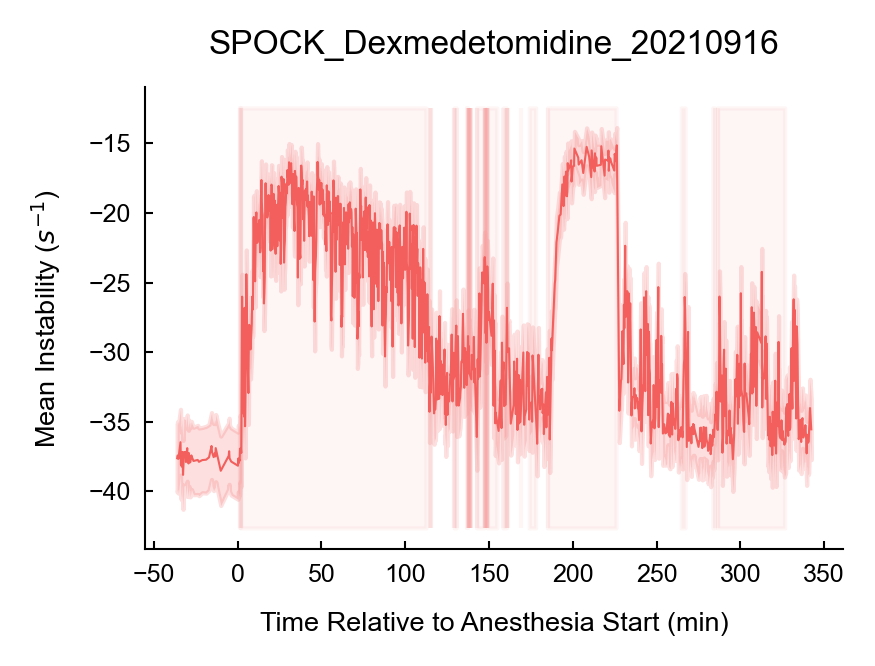

In [82]:
stab_means = delase_results[session][area].stability_params.apply(lambda x: x[:int(0.1*len(x))].mean())
stab_sems = delase_results[session][area].stability_params.apply(lambda x: x[:int(0.1*len(x))].std()/np.sqrt(len(x[:int(0.1*len(x))])))
time_vals = (delase_results[session][area].window_start - infusion_start)/60
plt.plot(time_vals, stab_means, color=curve_colors['dexmedetomidine'])
plt.fill_between(time_vals, stab_means - stab_sems, stab_means + stab_sems, alpha=0.2, color=curve_colors['dexmedetomidine'])
# Get time points where pct_correct > 0.25
high_perf_times = (pct_correct_windows - infusion_start)/60
high_perf_mask = (pct_correct <= 0.1) & (pct_correct_windows > infusion_start)


# Fill background for high performance periods
plt.fill_between(high_perf_times, plt.ylim()[0], plt.ylim()[1], 
                where=high_perf_mask,
                color=loc_roc_colors['dexmedetomidine'], alpha=0.1)
plt.xlabel('Time Relative to Anesthesia Start (min)')
plt.ylabel('Mean Instability ($s^{-1}$)')
plt.title(f'{session}')
plt.show()